# **Providing data-driven suggestions for HR Project**

### Import packages

In [231]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
from matplotlib import pyplot as plt
import seaborn as sns 

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import plot_importance

# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Important tools for evaluation.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer

# Import packages for statistical analysis/hypothesis testing
import statsmodels.formula.api as mle

### Load dataset

In [2]:
# Load dataset into a dataframe
df0 = pd.read_csv('HR_comma_sep.csv')

# Rename all column names in snake_case, correct misspelled, make column names more concise
df_rename = df0.rename(columns={"last_evaluation": "last_performance_scr","number_project": "num_projects"
                    , "average_montly_hours": "avg_monthly_hours", "time_spend_company": "tenure"
                    , "Work_accident": "had_work_accident", "left": "had_left_company"
                    , "promotion_last_5years": "promoted_last_5_years", "Department": "department", "salary": "paid_rate"})
df_rename.info()
print('\nCheck for missing values\n',df_rename.isna().sum())
print('\nCheck for duplicates: ',df_rename.duplicated().sum())
df_rename.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_performance_scr   14999 non-null  float64
 2   num_projects           14999 non-null  int64  
 3   avg_monthly_hours      14999 non-null  int64  
 4   tenure                 14999 non-null  int64  
 5   had_work_accident      14999 non-null  int64  
 6   had_left_company       14999 non-null  int64  
 7   promoted_last_5_years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   paid_rate              14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB

Check for missing values
 satisfaction_level       0
last_performance_scr     0
num_projects             0
avg_monthly_hours        0
tenure                   0
had_work_accident        0
had_left_company

,satisfaction_level,last_performance_scr,num_projects,avg_monthly_hours,tenure,had_work_accident,had_left_company,promoted_last_5_years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Data exploration

<Axes: >

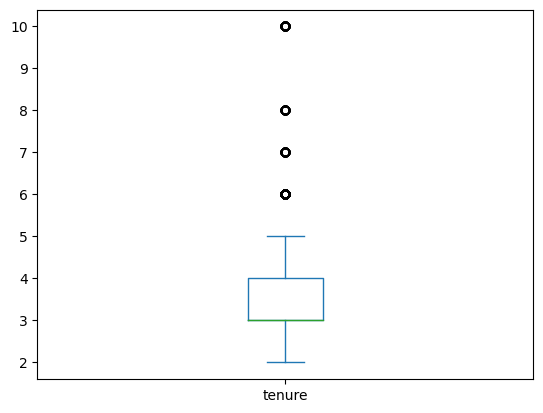

In [3]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df_drop = df_rename.drop_duplicates()
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
df_drop['tenure'].plot.box()

<Axes: >

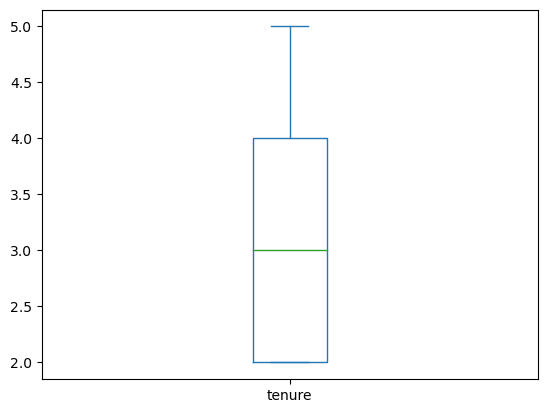

In [4]:
# Determine the number of rows containing outliers
lo = 2.5*df_drop['tenure'].quantile(.25) - 1.5*df_drop['tenure'].quantile(.75)
up = 2.5*df_drop['tenure'].quantile(.75) - 1.5*df_drop['tenure'].quantile(.25)
#lower = df_drop['tenure'].quantile(.25)-1.5*(df_drop['tenure'].quantile(.75)-df_drop['tenure'].quantile(.25))
#upper = df_drop['tenure'].quantile(.75)+1.5*(df_drop['tenure'].quantile(.75)-df_drop['tenure'].quantile(.25))
df_remove = df_drop[(df_drop['tenure']>lo)&(df_drop['tenure']<up)]
df_remove['tenure'].plot.box()

In [5]:
# Dataframe for visualizations
df_not =df_remove[df_remove['had_left_company']==0]
df_left = df_remove[df_remove['had_left_company']==1]

print('numbers of people who left',df_left.shape[0])
print('numbers of people who stayed',df_not.shape[0])

numbers of people who left 1882
numbers of people who stayed 9285


### Data visualizations

The average turnover rate 16.392902050587935


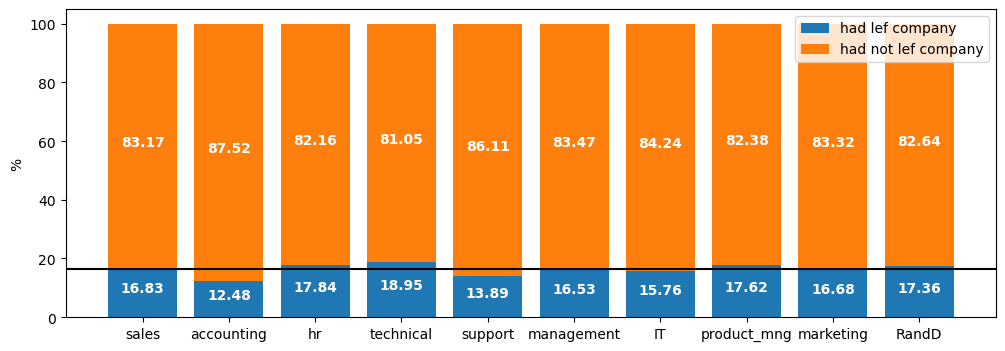

In [20]:
# Visualize the role of departments in an average turnover rate of 16.4%
df_count = df_remove.groupby(["department"]).count()
df_count_left =  df_left.groupby(["department"]).count()
df_count_not_left =  df_not.groupby(["department"]).count()

# Data
groups = df_remove['department'].unique()
values1 = df_count_left['tenure']/df_count['tenure']*100
values2 = df_count_not_left['tenure']/df_count['tenure']*100

fig, ax = plt.subplots(figsize=(12, 4))

# Stacked bar chart
ax.bar(groups, values1, label = "had lef company")
ax.bar(groups, values2, bottom = values1, label = "had not lef company")
ax.axhline(y = values1.mean(), color = 'k', linestyle = '-')

# Labels
for bar in ax.patches:
  ax.text(bar.get_x() + bar.get_width() / 2,
          bar.get_height() / 2 + bar.get_y(),
          round(bar.get_height(),2), ha = 'center',
          color = 'w', weight = 'bold', size = 10)

ax.legend()
ax.set_ylabel('%')
print('The average turnover rate',values1.mean())

Text(0.5, 0, 'paid_rate')

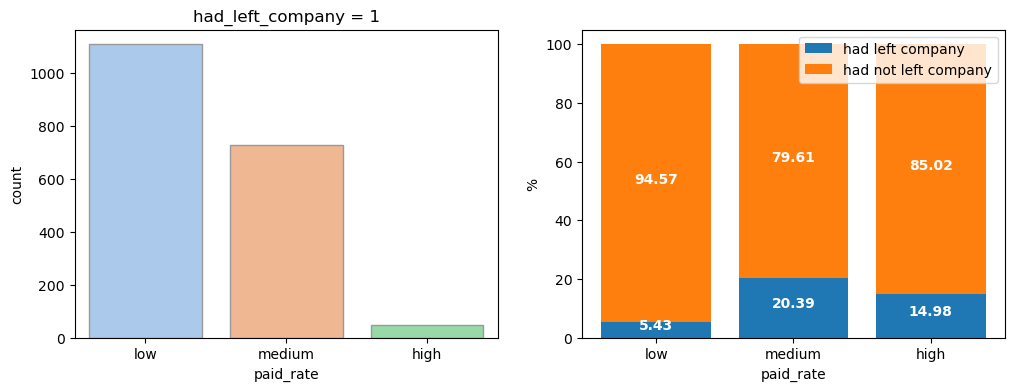

In [21]:
# Visualize the role of paid rate in turnover rate
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart for paid rate of employees who have left
sns.countplot(data=df_left, x="paid_rate",palette="pastel", edgecolor=".6", ax=axs[0]).set(title='had_left_company = 1')
df_count = df_remove.groupby(["paid_rate"]).count()
df_count_left =  df_left.groupby(["paid_rate"]).count()
df_count_not_left =  df_not.groupby(["paid_rate"]).count()

# Data
groups = df_remove['paid_rate'].unique()
values1 = df_count_left['tenure']/df_count['tenure']*100
values2 = df_count_not_left['tenure']/df_count['tenure']*100

# Stacked bar chart of turnover ratio by paid rate
axs[1].bar(groups, values1, label = "had left company")
axs[1].bar(groups, values2, bottom = values1, label = "had not left company")

# Labels
for bar in axs[1].patches:
  axs[1].text(bar.get_x() + bar.get_width() / 2,
          bar.get_height() / 2 + bar.get_y(),
          round(bar.get_height(),2), ha = 'center',
          color = 'w', weight = 'bold', size = 10)

axs[1].legend()
axs[1].set_ylabel('%')
axs[1].set_xlabel('paid_rate')

Text(0, 0.5, '% promoted')

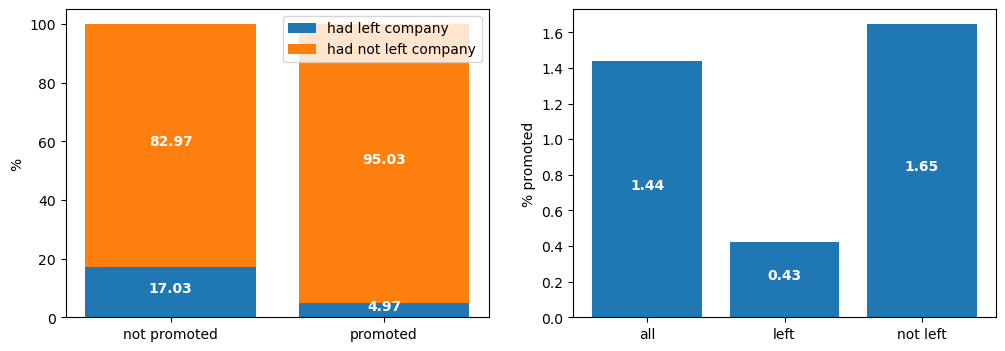

In [22]:
# Visualizing the role of whether or not  have been promoted in the past 5 years on turnover rate
promoted = df_remove["promoted_last_5_years"].sum()
not_promoted = df_remove.shape[0]-promoted
# Number of employees promoted and not promoted in last 5 years who left the company
promoted_left =  df_left["promoted_last_5_years"].sum()
not_promted_left = df_left.shape[0]-promoted_left
# Number of employees promoted and not promoted in last 5 years who not left the company
promoted_not_left =  df_not["promoted_last_5_years"].sum()
not_promoted_not_left = df_not.shape[0]-promoted_not_left

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Turnover ratio data
last_5_years = ['not promoted', 'promoted']
values1 = [not_promted_left/not_promoted*100,promoted_left/promoted*100]
values2 = [not_promoted_not_left/not_promoted*100,promoted_not_left/promoted*100]
# Stacked bar chart for turnover ratio whether promoted
axs[0].bar(last_5_years, values1, label = "had left company")
axs[0].bar(last_5_years, values2, bottom = values1, label = "had not left company")
# Labels
for bar in axs[0].patches:
  axs[0].text(bar.get_x() + bar.get_width() / 2,
          bar.get_height() / 2 + bar.get_y(),
          round(bar.get_height(),2), ha = 'center',
          color = 'w', weight = 'bold', size = 10)
axs[0].legend()
axs[0].set_ylabel('%')

# Promoted data
groups = ['all', 'left', 'not left']
values1 = [promoted/df_remove.shape[0]*100, promoted_left/df_left.shape[0]*100, promoted_not_left/df_not.shape[0]*100]
# Bar chart for average last 5 years promoted
axs[1].bar(groups, values1)
# Labels
for bar in axs[1].patches:
  axs[1].text(bar.get_x() + bar.get_width() / 2,
          bar.get_height() / 2 + bar.get_y(),
          round(bar.get_height(),2), ha = 'center',
          color = 'w', weight = 'bold', size = 10)

axs[1].set_ylabel('% promoted')

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


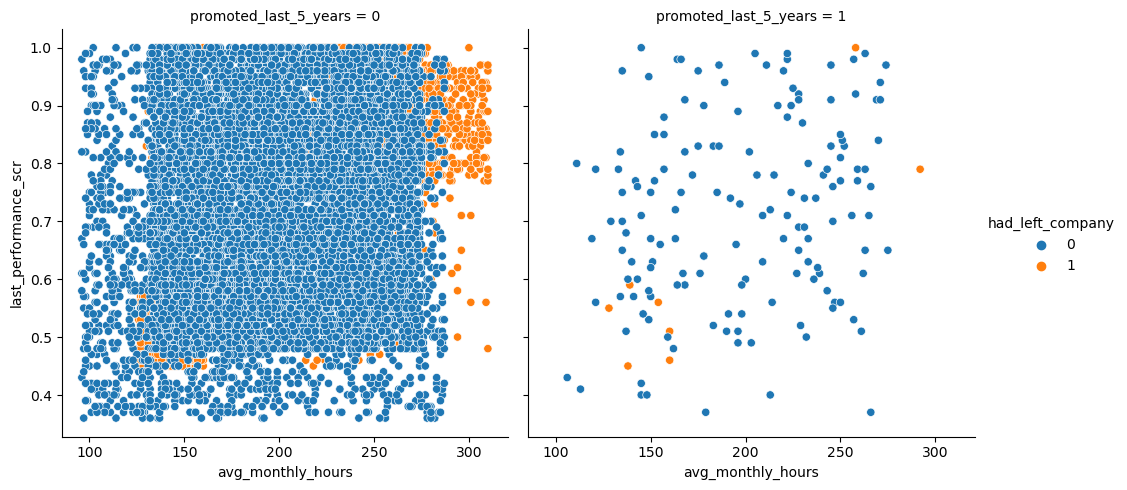

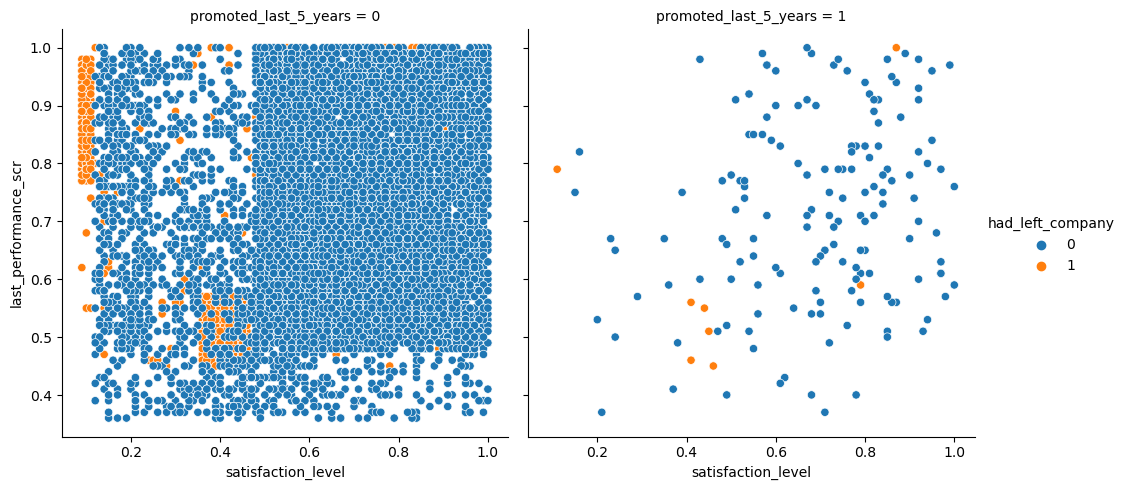

In [6]:
# Visualization of employee promotion distribution by performance rating and job satisfaction
sns.relplot(data=df_remove,x="avg_monthly_hours", y="last_performance_scr", hue="had_left_company", col="promoted_last_5_years",)
sns.relplot(data=df_remove,x="satisfaction_level", y="last_performance_scr", hue="had_left_company", col="promoted_last_5_years",)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


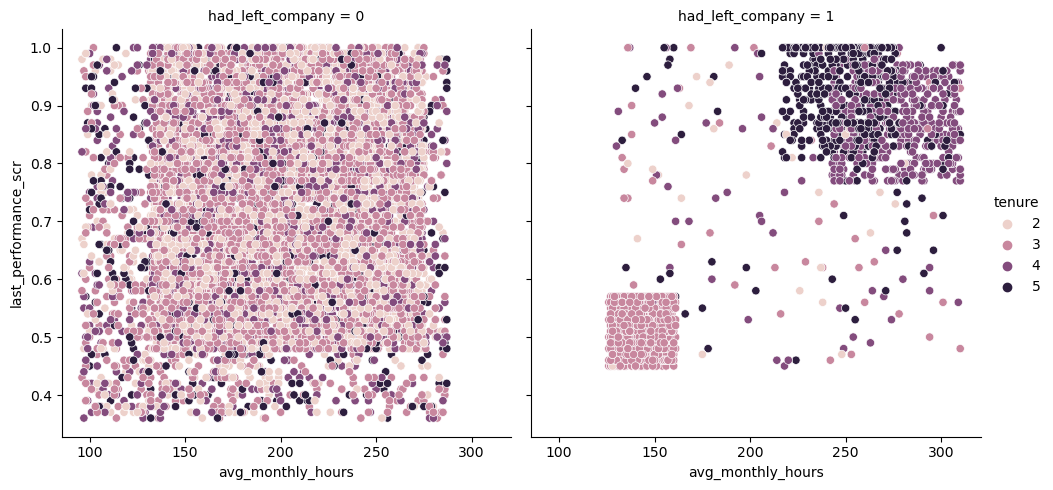

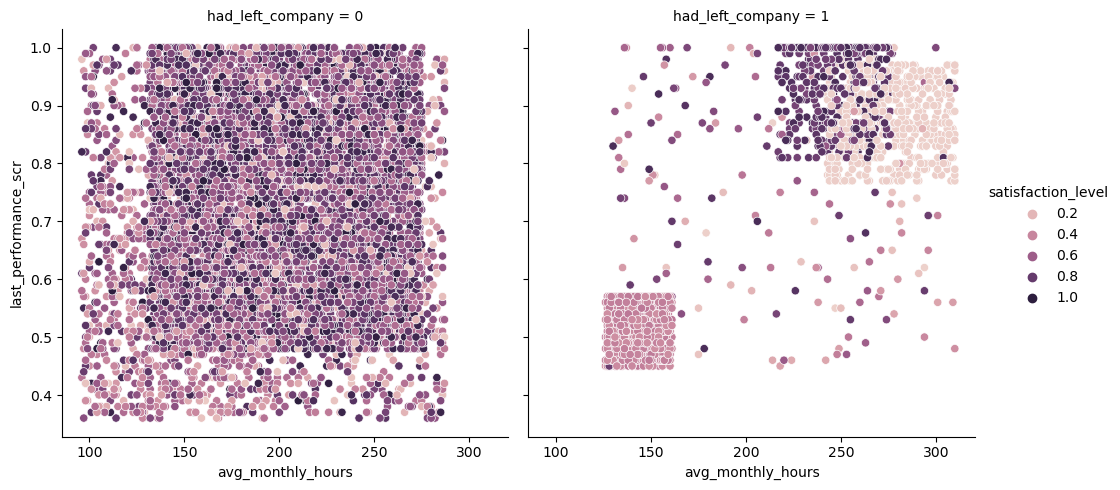

In [7]:
# Visualization of the distribution of employees who left the company by average hours worked per month, years worked at the company, and job satisfaction
sns.relplot(data=df_remove,x="avg_monthly_hours", y="last_performance_scr", hue="tenure", col="had_left_company",)
sns.relplot(data=df_remove,x="avg_monthly_hours", y="last_performance_scr", hue="satisfaction_level", col="had_left_company",)

### Insights
- The difference between the departments with the highest (technical- 18.95%) and lowest (accounting - 12.48%) turnover rates is about 6.47%. With an average turnover rate of 16.4%, this is a large enough difference to suggest that departments may play a role in reflecting differences in work environment, job stress, working conditions, or cultural factors between departments.
- High-pay rate employees are less likely to leave a company due to satisfaction with compensation and benefits. At the same time, low-pay rate employees are also more likely to stay because they have few other options or lower expectations. Moderate income levels are a more important factor in the decision to leave a company, as this group has the highest turnover rate. However, low pay rates also play an important role, as the high number of low-income employees leaving suggests this is also a significant issue.
- The rate of leaving the company among the group of employees who were not promoted (17.03%) was much higher than the rate of leaving the company among the group who were promoted (4.97%). This suggests that not being promoted may be an important factor in making employees feel dissatisfied and decide to leave the company.
- High performers who are not promoted and feel dissatisfied tend to leave the company because they feel their efforts are not being rewarded. Low-average performers also leave the company when they do not see opportunities for growth and satisfaction in their work.
- High performance scores combined with very low satisfaction were the key factors leading to turnover, despite relatively high productivity among employees working over 250 hours per month. High performance but a sense of stagnation or lack of growth opportunities may have been a factor in those working over 200 hours per month deciding to leave the company after five years.

### Data preprocessing

In [6]:
# One-hot encode remaining categorical values
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
one_hot_encoded = ohe.fit_transform(df_remove[['department','paid_rate']])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out())
one_hot_df.index = df_remove.index
# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([df_remove, one_hot_df], axis=1)

# Isolate features
X = df_encoded.copy()
# Isolate target variable
y = X['had_left_company']
# Drop unnecessary columns
X = X.drop(['had_left_company','department','paid_rate'], axis=1)

# Split data into training and testing sets, 80/20.
X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.2, random_state=12)
# Split the testing set into testing and validation sets, 50/50, to result in a final ratio of 80/10/10 for train/validate/test sets.
X_test, X_val, y_test, y_val = train_test_split(X_t, y_t, test_size=0.50, random_state=12)

print('FP = predicts that employees will leave the company (left = 1), but they actually want to stay (left = 0).\nWastes resources when the company implements unnecessary retention measures.\n')
print('FN = predicts that employees will stay the company (left = 0), but they actually want to leave (left = 1).\nLoses valuable employees when necessary retention measures are not implemented.\n')
print('Losing valuable employees can seriously affect the company''s operations and performance.\nTherefore, Recall score should be prioritized in refit GridSearchCV to minimize the number of FNs.')


FP = predicts that employees will leave the company (left = 1), but they actually want to stay (left = 0).
Wastes resources when the company implements unnecessary retention measures.

FN = predicts that employees will stay the company (left = 0), but they actually want to leave (left = 1).
Loses valuable employees when necessary retention measures are not implemented.

Losing valuable employees can seriously affect the companys operations and performance.
Therefore, Recall score should be prioritized in refit GridSearchCV to minimize the number of FNs.


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### XGBoost Classifier Modeling

In [7]:
%%time
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=12)
# Create a dictionary of hyperparameters to tune
xgb_params = {'max_depth': [5,10,15],
             'min_child_weight': [2, 8, 10],
             'learning_rate': [0.01, 0.1, 0.2],
             'n_estimators': [50, 100, 500]
             }
# Define a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}
# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb,
                      xgb_params,
                      scoring = scoring,
                      cv = 10,
                      refit = 'recall'
                     )
xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv.best_params_

CPU times: total: 35min 52s
Wall time: 3min 29s


best score: 0.9187303938654583
accuracy score: 0.9776186213070726
precision score: 0.9685863874345549
recall score: 0.9068627450980392
f1 score: 0.9367088607594937
XGBoost model:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       913
           1       0.97      0.91      0.94       204

    accuracy                           0.98      1117
   macro avg       0.97      0.95      0.96      1117
weighted avg       0.98      0.98      0.98      1117



{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 2,
 'n_estimators': 500}

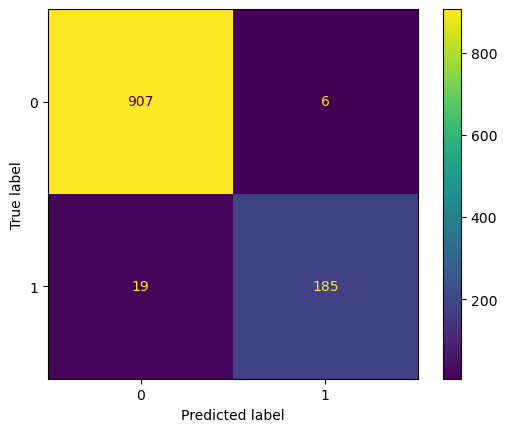

In [8]:
# Classification metrics on the validation set
valid_pred = xgb_cv.predict(X_val)
print('best score:', xgb_cv.best_score_)
accuracy = accuracy_score(y_val, valid_pred)
print('accuracy score:', accuracy)
precision = precision_score(y_val, valid_pred)
print('precision score:', precision)
recall = recall_score(y_val, valid_pred)
print('recall score:', recall)
f1_scr  = f1_score(y_val, valid_pred)
print('f1 score:', f1_scr)
print('XGBoost model:')

matrix = confusion_matrix(y_val, valid_pred)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = [0, 1]).plot()
print('\n',classification_report(y_val, valid_pred))

best score: 0.9187303938654583
accuracy score: 0.9892569382273948
precision score: 0.9810126582278481
recall score: 0.9451219512195121
f1 score: 0.9627329192546583
XGBoost model:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99       953
           1       0.98      0.95      0.96       164

    accuracy                           0.99      1117
   macro avg       0.99      0.97      0.98      1117
weighted avg       0.99      0.99      0.99      1117



<Axes: title={'center': 'Feature importance'}, xlabel='Average Gain', ylabel='Features'>

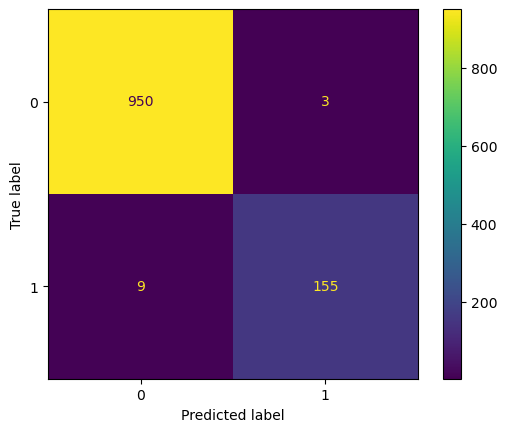

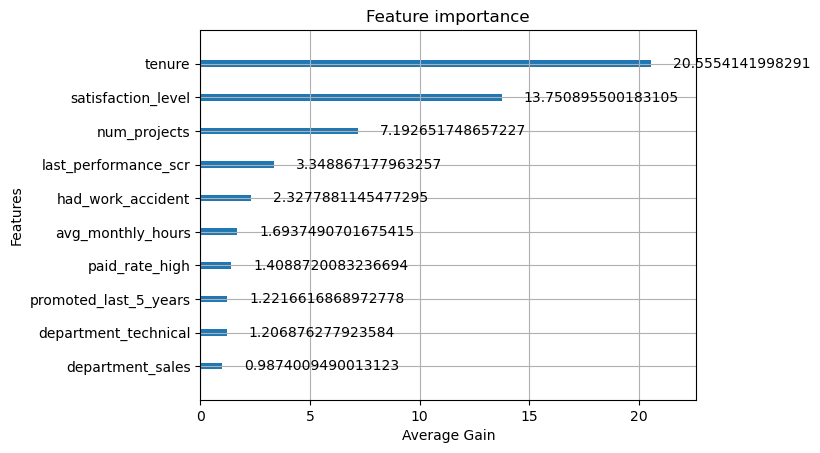

In [9]:
# Classification metrics on the test set
test_pred = xgb_cv.predict(X_test)
print('best score:', xgb_cv.best_score_)
accuracy = accuracy_score(y_test, test_pred)
print('accuracy score:', accuracy)
precision = precision_score(y_test, test_pred)
print('precision score:', precision)
recall = recall_score(y_test, test_pred)
print('recall score:', recall)
f1_scr  = f1_score(y_test, test_pred)
print('f1 score:', f1_scr)
print('XGBoost model:')

matrix = confusion_matrix(y_test, test_pred)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = [0, 1]).plot()
print('\n',classification_report(y_test, test_pred))
plot_importance(xgb_cv.best_estimator_, xlabel='Average Gain', importance_type='gain', max_num_features=10)

#### Feature engineering

['paid_rate_medium']

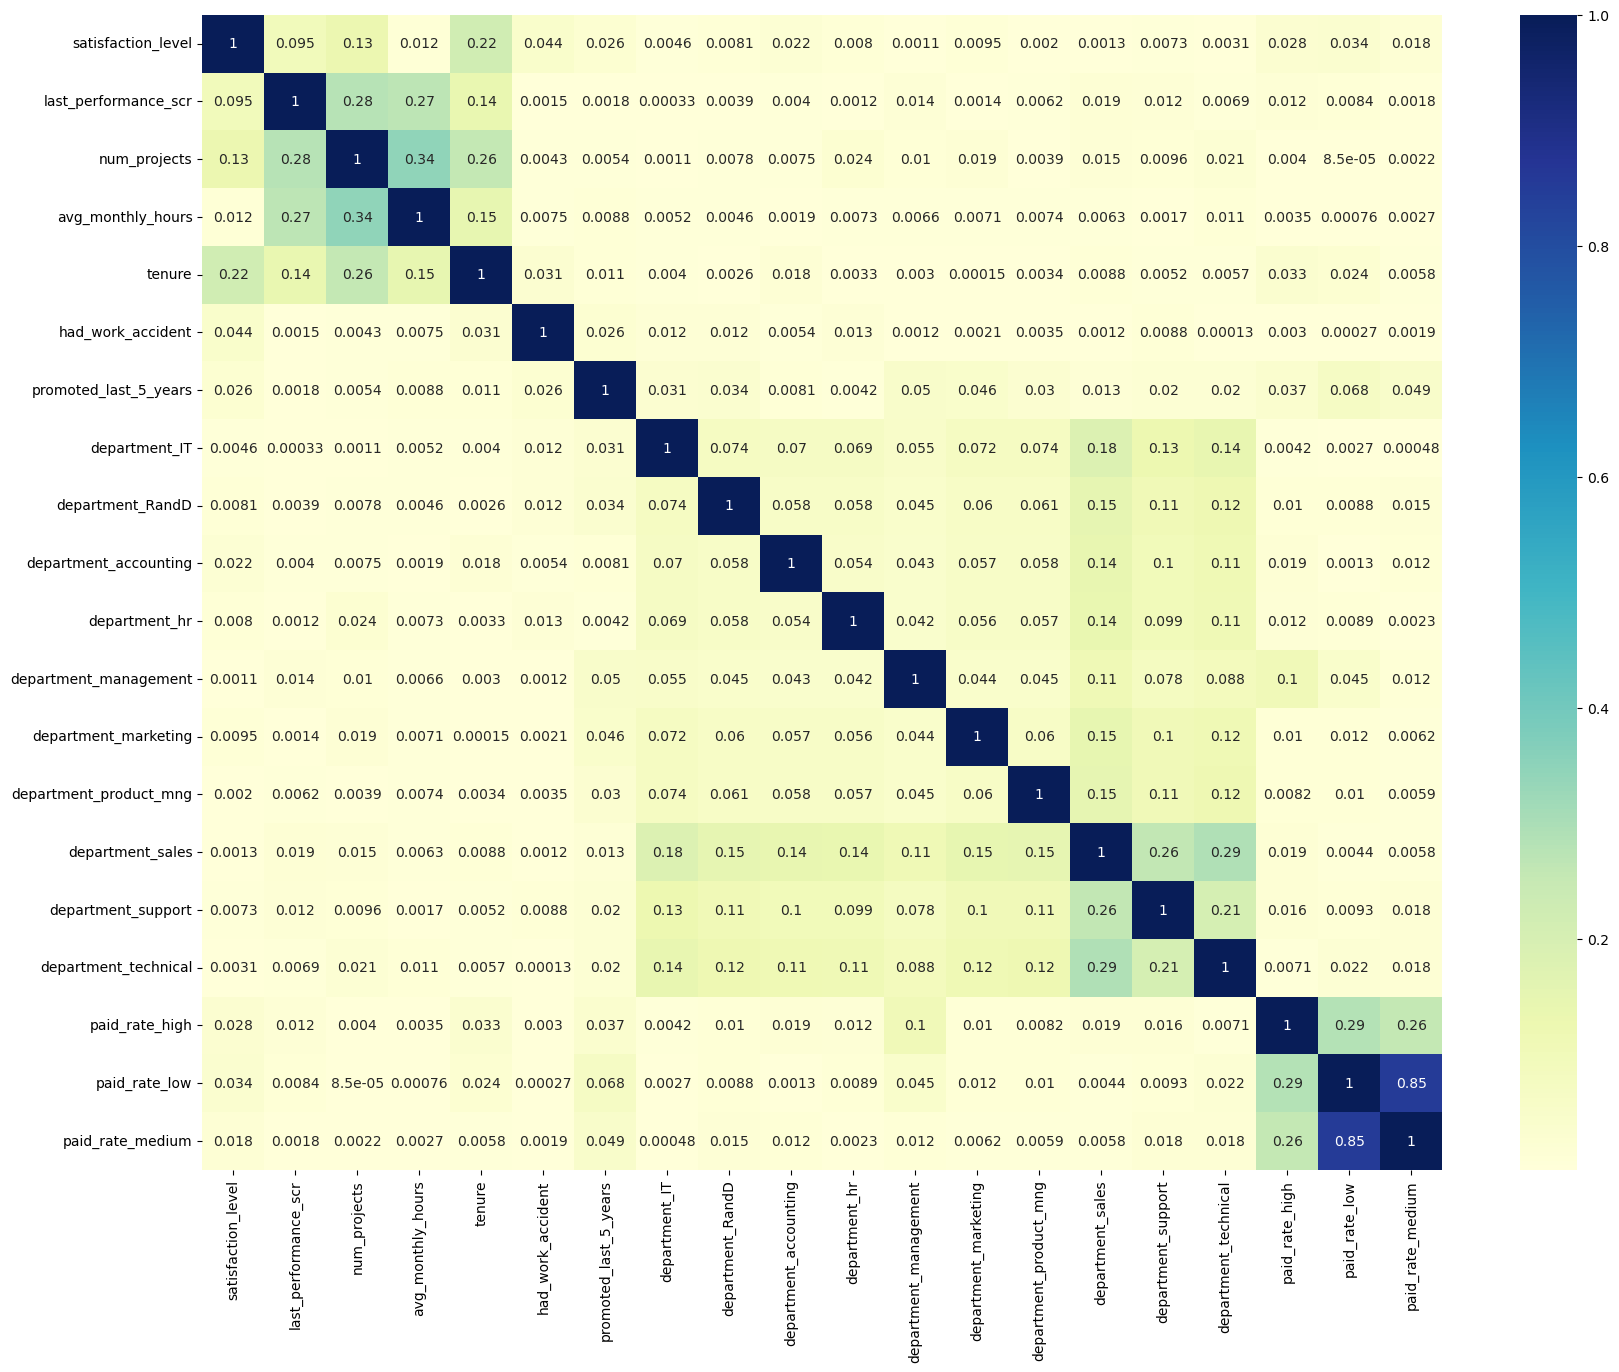

In [11]:
# plotting absolute value correlation matrix heatmap
plt.figure(figsize=(20,15))
cor_mx = X.corr().abs()
sns.heatmap(cor_mx, cmap="YlGnBu", annot=True)
# upper triangle of correlations
threshold = cor_mx.where(np.triu(np.ones(cor_mx.shape), k=1).astype(bool))
# select columns with correlations above threshold
to_reduced = [column for column in threshold.columns if any(threshold[column] > 0.7)]
# reduce the columns
df_reduced = df_encoded.drop([to_reduced[0],'department','paid_rate'], axis=1)
to_reduced

In [98]:
importances = xgb_cv.best_estimator_.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(importances.items(), columns=['Feature', 'Gain']).sort_values(by='Gain', ascending=False)

# 5 most importance features from XGBoost
X_train_imp = X_train[importance_df['Feature'].head()]
X_val_imp = X_val[importance_df['Feature'].head()]
X_test_imp = X_test[importance_df['Feature'].head()]

# reduced high correlate features
X_train_reduced = X_train.drop(columns=to_reduced)
X_val_reduced= X_val.drop(columns=to_reduced)
X_test_reduced = X_test.drop(columns=to_reduced)

# scale the features
X_train_scaled = StandardScaler().fit_transform(X_train)
X_val_scaled = StandardScaler().fit_transform(X_val)
X_test_scaled = StandardScaler().fit_transform(X_test)

importance_df.head(5)

,Feature,Gain
4,tenure,20.555414
0,satisfaction_level,13.750896
2,num_projects,7.192652
1,last_performance_scr,3.348867
5,had_work_accident,2.327788


### Logistic Regression Modeling

In [78]:
LR = LogisticRegression(random_state=12)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_val)
print('\nLogistic Regression model:\n',classification_report(y_val, y_pred))

LR_imp = LogisticRegression(random_state=12)
LR_imp.fit(X_train_imp, y_train)
y_pred_imp = LR_imp.predict(X_val_imp)
print('\nLogistic Regression model(high importance features):\n',classification_report(y_val, y_pred_imp))

LR_reduced = LogisticRegression(random_state=12)
LR_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = LR_reduced.predict(X_val_reduced)
print('\nLogistic Regression model(low correlate features):\n',classification_report(y_val, y_pred_reduced))

LR_scaled = LogisticRegression(random_state=12)
LR_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = LR_scaled.predict(X_val_scaled)
print('\nLogistic Regression model(scaled features):\n',classification_report(y_val, y_pred_scaled))


Logistic Regression model:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       913
           1       0.46      0.25      0.32       204

    accuracy                           0.81      1117
   macro avg       0.65      0.59      0.60      1117
weighted avg       0.78      0.81      0.79      1117


Logistic Regression model(high importance features):
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       913
           1       0.48      0.26      0.34       204

    accuracy                           0.81      1117
   macro avg       0.66      0.60      0.61      1117
weighted avg       0.78      0.81      0.79      1117


Logistic Regression model(low correlate features):
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       913
           1       0.46      0.24      0.31       204

    accuracy                           0.81  

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

### Upsampling minority class

In [81]:
print(df_remove["had_left_company"].value_counts(normalize=True)*100)

# Hàm tùy chỉnh cho việc upsampling
def upsample_minority(X_train, y_train, X_test, y_test, ratio):
    # Tách lớp đa số và lớp thiểu số
    X_majority = X_train[y_train == 0]
    X_minority = X_train[y_train == 1]
    y_majority = y_train[y_train == 0]
    y_minority = y_train[y_train == 1]
    
    # Tính toán số lượng mẫu thiểu số cần thiết
    upsampling_length = int(len(X_train) * ratio)
    
    # Thực hiện upsampling trên lớp thiểu số
    X_minority_upsampled, y_minority_upsampled = resample(
        X_minority, y_minority,
        replace=True,
        n_samples=upsampling_length,
        random_state=12
    )
    
    # Kết hợp lại dữ liệu sau khi upsampling
    X_upsampled = np.vstack((X_majority, X_minority_upsampled))
    y_upsampled = np.hstack((y_majority, y_minority_upsampled))
    
    # evaluate upsampled logistic regression model on validation set
    LR_upsampling = LogisticRegression(random_state=12)
    LR_upsampling.fit(X_upsampled, y_upsampled)
    y_pred_LR_upsampling = LR_upsampling.predict(X_test)

    print(f'\nClassification Report for {ratio:.0%} minority class upsampled Model:\n',classification_report(y_test, y_pred_LR_upsampling))
    return LR_upsampling


# Đánh giá mô hình trên tập kiểm tra
upsample_minority(X_train, y_train, X_val, y_val,ratio=0.20)
upsample_minority(X_train, y_train, X_val, y_val,ratio=0.25)
upsample_minority(X_train, y_train, X_val, y_val,ratio=0.30)
upsample_minority(X_train, y_train, X_val, y_val,ratio=0.35)

had_left_company
0    83.146772
1    16.853228
Name: proportion, dtype: float64

Classification Report for 20% minority class upsampled Model:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89       913
           1       0.50      0.32      0.39       204

    accuracy                           0.82      1117
   macro avg       0.68      0.62      0.64      1117
weighted avg       0.79      0.82      0.80      1117


Classification Report for 25% minority class upsampled Model:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       913
           1       0.56      0.49      0.52       204

    accuracy                           0.84      1117
   macro avg       0.72      0.70      0.71      1117
weighted avg       0.83      0.84      0.83      1117


Classification Report for 30% minority class upsampled Model:
               precision    recall  f1-score   support

           0       

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocess


Classification Report for 35% minority class upsampled Model:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91       913
           1       0.58      0.68      0.62       204

    accuracy                           0.85      1117
   macro avg       0.75      0.78      0.76      1117
weighted avg       0.86      0.85      0.85      1117



LogisticRegression(random_state=12)

In [221]:
print("ON VALIDATION SET".center(60))
upsample_minority(X_train, y_train, X_val, y_val, ratio=0.30)
print("ON TEST SET".center(60))
upsample_minority(X_train, y_train, X_test, y_test, ratio=0.30)
print("ON IMPORTANT TEST SET".center(60))
upsample_minority(X_train_imp, y_train, X_test_imp, y_test, ratio=0.30)
print("ON REDUCED TEST SET".center(60))
upsample_minority(X_train_reduced, y_train, X_test_reduced, y_test, ratio=0.30)
print("ON SCALED TEST SET".center(60))
upsample_minority(X_train_scaled, y_train, X_test_scaled, y_test, ratio=0.30)

                     ON VALIDATION SET                      

Classification Report for 30% minority class upsampled Model:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       913
           1       0.58      0.60      0.59       204

    accuracy                           0.85      1117
   macro avg       0.74      0.75      0.75      1117
weighted avg       0.85      0.85      0.85      1117

                        ON TEST SET                         

Classification Report for 30% minority class upsampled Model:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       953
           1       0.51      0.66      0.58       164

    accuracy                           0.86      1117
   macro avg       0.73      0.78      0.75      1117
weighted avg       0.88      0.86      0.87      1117

                   ON IMPORTANT TEST SET                    

Classification Report for 30% mino

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocess

LogisticRegression(random_state=12)

                     ON SCALED TEST SET                     

Classification Report for 30% minority class upsampled Model:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92       953
           1       0.52      0.68      0.59       164

    accuracy                           0.86      1117
   macro avg       0.73      0.78      0.75      1117
weighted avg       0.88      0.86      0.87      1117



,Variable,Coefficient
4,tenure,1.134465
3,avg_monthly_hours,0.164883
18,paid_rate_low,0.155839
14,department_sales,0.082963
16,department_technical,0.020417


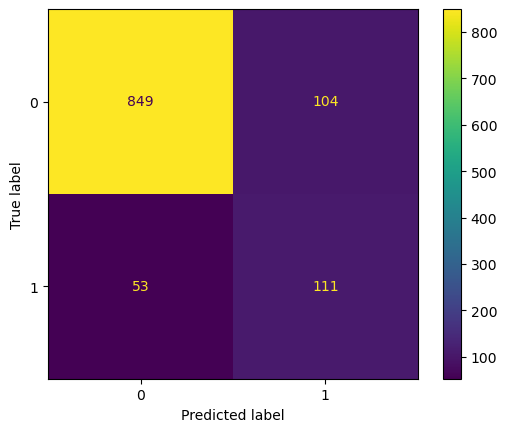

In [146]:
print("ON SCALED TEST SET".center(60))
LR_best_scaled = upsample_minority(X_train_scaled, y_train, X_test_scaled, y_test, ratio=0.30)
y_best_scaled = LR_best_scaled.predict(X_test_scaled)

cm_scaled = confusion_matrix(y_test, y_best_scaled)
ConfusionMatrixDisplay(confusion_matrix = cm_scaled, display_labels = [0, 1]).plot()

coefficients_scaled = LR_best_scaled.coef_[0]
coef_scaled = pd.DataFrame({'Features': X_test.columns, 'Coefficients': coefficients_scaled})
coef_scaled.sort_values(by='Coefficient',ascending=False).head(5)

### Hypothesis testing

In [236]:

df_stats = df_encoded[['had_left_company','had_work_accident','paid_rate_low','tenure','satisfaction_level','num_projects']]
model = mle.logit(formula='had_left_company ~ had_work_accident + paid_rate_low + tenure + satisfaction_level + num_projects', data=df_stats)
result = model.fit()

print('\nNull Hypothesis (H0) = There is NO difference in the likelihood of leaving the job between employee groups (when controlling   for tenure, satisfaction, and the number of projects). Essentially, the odds ratio for the employee group variable equals 1,   meaning no effect.')
print('\nAlternative Hypothesis(H1)=There IS a difference in the likelihood of leaving the job between employee groups(after accounting for the other variables). The odds ratio for the employee group variable is significantly different from 1, indicating either a higher or lower likelihood of turnover.\n')
print(result.summary())

coefficients_logit = model.fit().params.values
logit_df = pd.DataFrame(result.summary().tables[1].data)
pd.DataFrame({'Feature': logit_df.loc[1:,0].values, 'Coefficient': coefficients_logit,'Odds Ratio': np.exp(coefficients_logit)}).tail(5)

Optimization terminated successfully.
         Current function value: 0.322141
         Iterations 7

Null Hypothesis (H0) = There is NO difference in the likelihood of leaving the job between employee groups (when controlling   for tenure, satisfaction, and the number of projects). Essentially, the odds ratio for the employee group variable equals 1,   meaning no effect.

Alternative Hypothesis(H1)=There IS a difference in the likelihood of leaving the job between employee groups(after accounting for the other variables). The odds ratio for the employee group variable is significantly different from 1, indicating either a higher or lower likelihood of turnover.

                           Logit Regression Results                           
Dep. Variable:       had_left_company   No. Observations:                11167
Model:                          Logit   Df Residuals:                    11161
Method:                           MLE   Df Model:                            5
Date:      

,Feature,Coefficient,Odds Ratio
1,had_work_accident,-1.504393,0.222152
2,paid_rate_low,0.527413,1.694543
3,tenure,1.072799,2.923551
4,satisfaction_level,-4.494139,0.011174
5,num_projects,-0.404405,0.667374
